In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [3]:
inp=pd.read_csv("PJ sensor.csv",usecols=[6,7,10,11])
out=pd.read_csv("PJ sensor.csv",usecols=[2,3,4,5,8,9])

In [4]:
inp.head(5)

,Temperature,Relative Humidity,date,Time
0,31,65,191213,175844
1,31,65,191213,175904
2,31,65,191213,175924
3,31,65,191213,175944
4,31,66,191213,180004


In [5]:
out.head(5)

,NO2,O3,CO,SO2,PM2.5,PM10
0,-15.075377,35.714286,1766.233766,148.484848,11.229150,17.323938
1,-20.100503,41.208791,1733.766234,142.424242,9.413914,24.967407
2,-15.075377,43.956044,1711.038961,136.363636,10.350110,56.781536
3,0.000000,57.692308,1688.311688,139.393939,10.488765,30.371115
4,-20.100503,54.945055,1681.818182,130.303030,12.353048,188.026886


In [6]:
inp=np.array(inp)
out=np.array(out)

# Min Max Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
import warnings
scaler_obj=MinMaxScaler()
X1=scaler_obj.fit_transform(inp)
Y1=scaler_obj.fit_transform(out)

warnings.filterwarnings(action='ignore', category=UserWarning)

X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [8]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
Y1.shape

(1627533, 1, 6)

# Model

In [10]:
model1 = Sequential()
model1.add(keras.Input(shape=(1,4)))
model1.add(tf.keras.layers.GRU(6,activation="relu",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model1.add(keras.layers.Dropout(.1))
model1.add(Dense(6))
model1.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model1.add(keras.layers.ReLU())
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6)                 216       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
re_lu (ReLU)                 (None, 6)                 0         
Total params: 282
Trainable params: 270
Non-trainable params: 12
_________________________________________________________________


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

model_fit8 = model1.fit(x_train,y_train,batch_size=2048,epochs=300, validation_split=0.1)

Epoch 1/300
537/537 [==============================] - 186s 344ms/step - loss: 0.2518 - accuracy: 0.3080 - mse: 0.2510 - mae: 0.3229 - rmse: 0.4384 - val_loss: 0.0986 - val_accuracy: 0.2587 - val_mse: 0.0979 - val_mae: 0.2315 - val_rmse: 0.2996
Epoch 2/300
537/537 [==============================] - 193s 359ms/step - loss: 0.2284 - accuracy: 0.3130 - mse: 0.2277 - mae: 0.3128 - rmse: 0.4215 - val_loss: 0.1360 - val_accuracy: 0.2291 - val_mse: 0.1352 - val_mae: 0.2635 - val_rmse: 0.3457
Epoch 3/300
537/537 [==============================] - 202s 377ms/step - loss: 0.2079 - accuracy: 0.3216 - mse: 0.2072 - mae: 0.3032 - rmse: 0.4055 - val_loss: 0.1248 - val_accuracy: 0.2360 - val_mse: 0.1241 - val_mae: 0.2569 - val_rmse: 0.3342
Epoch 4/300
537/537 [==============================] - 155s 288ms/step - loss: 0.1906 - accuracy: 0.3377 - mse: 0.1899 - mae: 0.2942 - rmse: 0.3908 - val_loss: 0.1156 - val_accuracy: 0.2461 - val_mse: 0.1149 - val_mae: 0.2507 - val_rmse: 0.3240
Epoch 5/300
537/537 

537/537 [==============================] - 146s 272ms/step - loss: 0.0433 - accuracy: 0.6236 - mse: 0.0428 - mae: 0.1207 - rmse: 0.2018 - val_loss: 0.0397 - val_accuracy: 0.6776 - val_mse: 0.0392 - val_mae: 0.1141 - val_rmse: 0.1935
Epoch 35/300
537/537 [==============================] - 146s 272ms/step - loss: 0.0424 - accuracy: 0.6293 - mse: 0.0418 - mae: 0.1190 - rmse: 0.1995 - val_loss: 0.0388 - val_accuracy: 0.6828 - val_mse: 0.0383 - val_mae: 0.1128 - val_rmse: 0.1912
Epoch 36/300
537/537 [==============================] - 146s 272ms/step - loss: 0.0414 - accuracy: 0.6341 - mse: 0.0409 - mae: 0.1172 - rmse: 0.1971 - val_loss: 0.0378 - val_accuracy: 0.6886 - val_mse: 0.0373 - val_mae: 0.1114 - val_rmse: 0.1885
Epoch 37/300
537/537 [==============================] - 146s 272ms/step - loss: 0.0399 - accuracy: 0.6286 - mse: 0.0394 - mae: 0.1148 - rmse: 0.1933 - val_loss: 0.0366 - val_accuracy: 0.6720 - val_mse: 0.0361 - val_mae: 0.1094 - val_rmse: 0.1846
Epoch 38/300
537/537 [=======

537/537 [==============================] - 146s 273ms/step - loss: 0.0103 - accuracy: 0.9402 - mse: 0.0099 - mae: 0.0628 - rmse: 0.0924 - val_loss: 0.0102 - val_accuracy: 0.9411 - val_mse: 0.0098 - val_mae: 0.0623 - val_rmse: 0.0916
Epoch 68/300
537/537 [==============================] - 147s 273ms/step - loss: 0.0098 - accuracy: 0.9443 - mse: 0.0094 - mae: 0.0613 - rmse: 0.0898 - val_loss: 0.0096 - val_accuracy: 0.9455 - val_mse: 0.0092 - val_mae: 0.0603 - val_rmse: 0.0883
Epoch 69/300
537/537 [==============================] - 146s 271ms/step - loss: 0.0093 - accuracy: 0.9487 - mse: 0.0089 - mae: 0.0598 - rmse: 0.0873 - val_loss: 0.0090 - val_accuracy: 0.9500 - val_mse: 0.0086 - val_mae: 0.0588 - val_rmse: 0.0857
Epoch 70/300
537/537 [==============================] - 146s 272ms/step - loss: 0.0088 - accuracy: 0.9548 - mse: 0.0084 - mae: 0.0586 - rmse: 0.0851 - val_loss: 0.0087 - val_accuracy: 0.9563 - val_mse: 0.0084 - val_mae: 0.0584 - val_rmse: 0.0849
Epoch 71/300
537/537 [=======

537/537 [==============================] - 173s 321ms/step - loss: 0.0013 - accuracy: 0.9959 - mse: 0.0011 - mae: 0.0238 - rmse: 0.0306 - val_loss: 0.0013 - val_accuracy: 0.9964 - val_mse: 0.0011 - val_mae: 0.0238 - val_rmse: 0.0307
Epoch 101/300
537/537 [==============================] - 172s 321ms/step - loss: 0.0013 - accuracy: 0.9963 - mse: 0.0011 - mae: 0.0233 - rmse: 0.0301 - val_loss: 0.0013 - val_accuracy: 0.9966 - val_mse: 0.0011 - val_mae: 0.0232 - val_rmse: 0.0299
Epoch 102/300
537/537 [==============================] - 172s 321ms/step - loss: 0.0013 - accuracy: 0.9965 - mse: 0.0011 - mae: 0.0230 - rmse: 0.0297 - val_loss: 0.0013 - val_accuracy: 0.9967 - val_mse: 0.0011 - val_mae: 0.0229 - val_rmse: 0.0297
Epoch 103/300
537/537 [==============================] - 172s 320ms/step - loss: 0.0012 - accuracy: 0.9966 - mse: 0.0011 - mae: 0.0228 - rmse: 0.0295 - val_loss: 0.0012 - val_accuracy: 0.9968 - val_mse: 0.0011 - val_mae: 0.0228 - val_rmse: 0.0295
Epoch 104/300
537/537 [===

537/537 [==============================] - 173s 323ms/step - loss: 0.0011 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 134/300
537/537 [==============================] - 173s 323ms/step - loss: 0.0011 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 135/300
537/537 [==============================] - 174s 323ms/step - loss: 0.0011 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 136/300
537/537 [==============================] - 173s 323ms/step - loss: 0.0011 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 137/300
537/537 [===

537/537 [==============================] - 148s 275ms/step - loss: 0.0011 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 167/300
537/537 [==============================] - 147s 275ms/step - loss: 0.0011 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 168/300
537/537 [==============================] - 148s 275ms/step - loss: 0.0011 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 169/300
537/537 [==============================] - 148s 275ms/step - loss: 0.0011 - accuracy: 0.9970 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0011 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 170/300
537/537 [===

537/537 [==============================] - 147s 274ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 200/300
537/537 [==============================] - 147s 274ms/step - loss: 0.0010 - accuracy: 0.9970 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 201/300
537/537 [==============================] - 147s 274ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 202/300
537/537 [==============================] - 147s 274ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0291
Epoch 203/300
537/537 [===

537/537 [==============================] - 147s 273ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 233/300
537/537 [==============================] - 147s 273ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0224 - val_rmse: 0.0291
Epoch 234/300
537/537 [==============================] - 146s 273ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 235/300
537/537 [==============================] - 147s 273ms/step - loss: 0.0010 - accuracy: 0.9970 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 236/300
537/537 [===

537/537 [==============================] - 146s 273ms/step - loss: 0.0010 - accuracy: 0.9970 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0291
Epoch 266/300
537/537 [==============================] - 147s 274ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 267/300
537/537 [==============================] - 147s 273ms/step - loss: 0.0010 - accuracy: 0.9970 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 268/300
537/537 [==============================] - 147s 273ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290
Epoch 269/300
537/537 [===

537/537 [==============================] - 146s 272ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0225 - val_rmse: 0.0291
Epoch 299/300
537/537 [==============================] - 147s 274ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0291
Epoch 300/300
537/537 [==============================] - 158s 295ms/step - loss: 0.0010 - accuracy: 0.9969 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290 - val_loss: 0.0010 - val_accuracy: 0.9971 - val_mse: 0.0010 - val_mae: 0.0223 - val_rmse: 0.0290


# Saving Model as File

In [23]:
model_json = model1.to_json()
with open("Model_File/grupj.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("Model_File/grupj.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('Model_File/grupj.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model_File/grupj.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [25]:
loaded_model.evaluate(x_train, y_train)

38146/38146 [==============================] - 66s 2ms/step - loss: 0.0010 - accuracy: 0.9970 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290


[0.0010464127408340573,
 0.9969671964645386,
 0.0010464090155437589,
 0.02230764739215374,
 0.029004961252212524]

In [26]:
loaded_model.evaluate(x_test,y_test)

12716/12716 [==============================] - 22s 2ms/step - loss: 0.0010 - accuracy: 0.9970 - mse: 0.0010 - mae: 0.0223 - rmse: 0.0290


[0.0010424680076539516,
 0.9970064759254456,
 0.0010424698702991009,
 0.022266222164034843,
 0.028956182301044464]

# Error Analysis

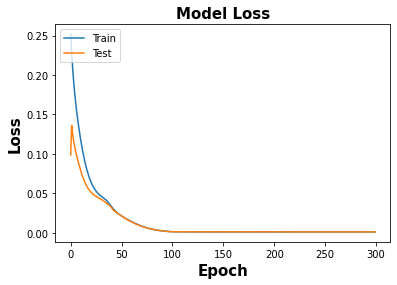

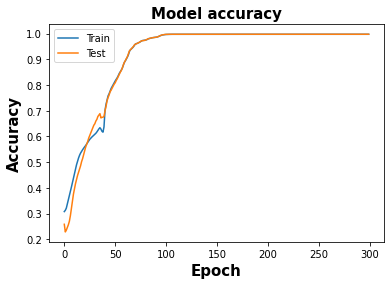

In [27]:
# summarize history for loss
plt.plot(model_fit8.history['loss'])
plt.plot(model_fit8.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_fit8.history['accuracy'])
plt.plot(model_fit8.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[0.4334275, 0.5546785, 0.       , 0.       , 0.0479142, 0.       ],
       [0.4334275, 0.5546785, 0.       , 0.       , 0.0479142, 0.       ],
       [0.4334275, 0.5546785, 0.       , 0.       , 0.0479142, 0.       ],
       ...,
       [0.4334275, 0.5546785, 0.       , 0.       , 0.0479142, 0.       ],
       [0.4334275, 0.5546785, 0.       , 0.       , 0.0479142, 0.       ],
       [0.4334275, 0.5546785, 0.       , 0.       , 0.0479142, 0.       ]],
      dtype=float32)

In [29]:
y_test

array([[[0.49655172, 0.61261671, 0.04625328, 0.00839927, 0.07680226,
         0.00349832]],

       [[0.40689655, 0.56779311, 0.02503314, 0.00862807, 0.03923826,
         0.00169898]],

       [[0.48275862, 0.61261671, 0.05669757, 0.01000087, 0.12197674,
         0.0061505 ]],

       ...,

       [[0.4       , 0.53897794, 0.02967504, 0.01022967, 0.04172884,
         0.01677347]],

       [[0.4137931 , 0.56779311, 0.03514586, 0.01114488, 0.06885241,
         0.003031  ]],

       [[0.48275862, 0.57739817, 0.06051056, 0.00908567, 0.10450044,
         0.00542992]]])

In [30]:
y_test=y_test[:,0]

In [31]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [32]:
from numpy import savetxt
savetxt('ARRAY_DATA/gru_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed